# Trading Signal Generation

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re

# Text Processing
import spacy
from transformers import AutoTokenizer, AutoModel

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

# Model Saving
import joblib

c:\Users\scaro\Downloads\fx-news-alpha\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [2]:
file_path1 = "data/raw/january/labeled_january.csv"
with open(file_path1, "r", encoding="utf-8") as file:
    df_jan = pd.read_csv(file)

file_path2 = "data/raw/february/labeled_february.csv"
with open(file_path2, "r", encoding="utf-8") as file:
    df_feb = pd.read_csv(file)

file_path3 = "data/raw/march/labeled_march.csv"
with open(file_path3, "r", encoding="utf-8") as file:
    df_march = pd.read_csv(file)

In [3]:
import re

def normalize_numbers(text):
    # Replace monetary values (e.g., "R$ 15 bilhões" → "15B")
    text = re.sub(r"R\$ ?([\d.,]+) bilhões", r"\1B", text)
    text = re.sub(r"R\$ ?([\d.,]+) milhões", r"\1M", text)
    # Standardize percentages (e.g., "0.5 pp" → "0.5%")
    text = re.sub(r"([\d.,]+) pp", r"\1%", text)
    # Standardize plain numbers (e.g., "15,000" → "15000")
    text = text.replace(",", "")
    return text

In [4]:
def remove_noise(text):
    # Remove dates and times
    text = re.sub(r"\b\d{1,2}[hH]\d{2}\b", "", text)  # Times like "17h20"
    text = re.sub(r"\b\d{1,2}ª[Ff]\b", "", text)       # Ordinals like "2ªF"
    # Remove redundant words
    text = re.sub(r"MAIS AGENDA|LÁ FORA|A BOLSA ESTÁ CARA", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
# Comprehensive dictionary for expanding acronyms
acronyms = {
    "Selic": "Sistema Especial de Liquidação e de Custódia",
    "PIB": "Produto Interno Bruto",
    "CDI": "Certificado de Depósito Interbancário",
    "LPRs": "Loan Prime Rates",
    "Ibovespa": "Índice Bovespa",
    "BB": "Banco do Brasil",
    "BC": "Banco Central",
    "FGTS": "Fundo de Garantia do Tempo de Serviço",
    "STF": "Supremo Tribunal Federal",
    "CPI": "Índice de Preços ao Consumidor",
    "MP": "Medida Provisória",
    "EUA": "Estados Unidos",
    "ONU": "Organização das Nações Unidas",
    "FGV": "Fundação Getúlio Vargas",
    "IBGE": "Instituto Brasileiro de Geografia e Estatística",
    "BNDES": "Banco Nacional de Desenvolvimento Econômico e Social",
    "IPCA": "Índice Nacional de Preços ao Consumidor Amplo",
    "DI": "Depósito Interfinanceiro",
    "IR": "Imposto de Renda",
    "OI": "Operadora Oi",
    "CV": "Câmara de Vereadores"
}

noisy_acronyms = {"ROMI", "ENEVA", "LIGHT", "DA"}

def expand_acronyms(text, acronym_dict):
    for acronym, full_form in acronym_dict.items():
        text = re.sub(rf'\b{re.escape(acronym)}\b', full_form, text, flags=re.IGNORECASE)
    return text

def remove_noisy_acronyms(text, noisy_set):
    return re.sub(r'\b(?:' + '|'.join(noisy_set) + r')\b', '', text)

In [6]:
import spacy

# Load Portuguese spaCy model
nlp = spacy.load("pt_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

In [7]:
def preprocess_text(text):
    text = normalize_numbers(text)         
    text = expand_acronyms(text, acronyms)
    text = remove_noisy_acronyms(text, noisy_acronyms)
    text = lemmatize_text(text)          
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Apply preprocessing to the dataset
df_jan['cleaned_article'] = df_jan['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_feb['cleaned_article'] = df_feb['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_march['cleaned_article'] = df_march['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)

label
 0    556
-1    363
 1    182
Name: count, dtype: int64


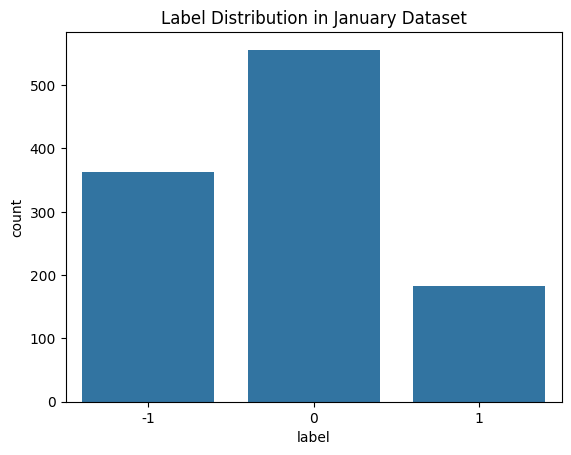

In [8]:
print(df_jan['label'].value_counts())
sns.countplot(x='label', data=df_jan)
plt.title('Label Distribution in January Dataset')
plt.savefig("results/bert_embeddings_experiment_v1/figures/label_distribution_january.png")

label
 0    649
-1    157
 1    113
Name: count, dtype: int64


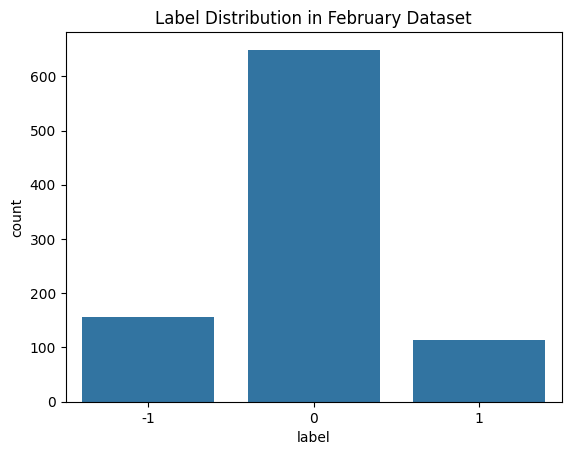

In [9]:
print(df_feb['label'].value_counts())
sns.countplot(x='label', data=df_feb)
plt.title('Label Distribution in February Dataset')
plt.savefig("results/bert_embeddings_experiment_v1/figures/label_distribution_february.png")

label
 0    542
-1    123
 1     48
Name: count, dtype: int64


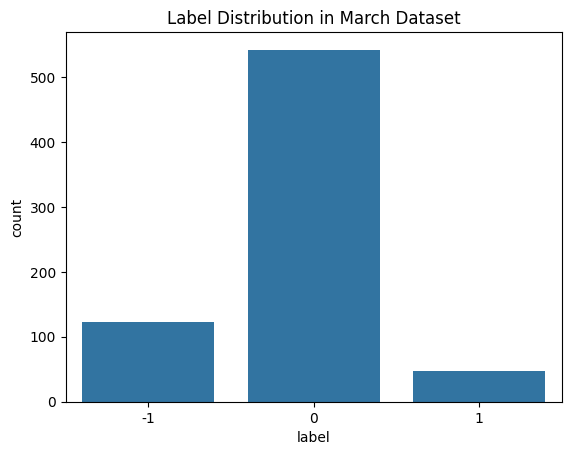

In [10]:
print(df_march['label'].value_counts())
sns.countplot(x='label', data=df_march)
plt.title('Label Distribution in March Dataset')
plt.savefig("results/bert_embeddings_experiment_v1/figures/label_distribution_march.png")

In [11]:
# Load BERTimbau tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

def get_bert_embedding(text, tokenizer, model):
    # tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # pass inputs through model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract [CLS] token embedding (shape: [batch_size, hidden_size])
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token
    return cls_embedding.squeeze(0).numpy()  # convert to NumPy array

In [13]:
df_jan['embedding'] = df_jan['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))
df_feb['embedding'] = df_feb['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))
df_march['embedding'] = df_march['cleaned_article'].apply(lambda x: get_bert_embedding(x, tokenizer, model))

## Logistic Regression Classification

In [14]:
# Combine January and February data for training
df_train_multi = pd.concat([df_jan, df_feb])
X_train_multi = np.vstack(df_train_multi['embedding'].values)
y_train_multi = df_train_multi['label']

# multi classification and test on march
X_test_multi = np.vstack(df_march['embedding'].values)
y_test_multi = df_march['label']

# binary Classification and test on march
df_train_binary = df_train_multi[df_train_multi['label'] != 0]
df_march_binary = df_march[df_march['label'] != 0]

X_train_binary = np.vstack(df_train_binary['embedding'].values)
y_train_binary = df_train_binary['label']

X_test_binary = np.vstack(df_march_binary['embedding'].values)
y_test_binary = df_march_binary['label']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train multi-class classifier
multi_clf = LogisticRegression(max_iter=1000)
multi_clf.fit(X_train_multi, y_train_multi)

# Predict and evaluate
y_pred_multi = multi_clf.predict(X_test_multi)
print("Multi-Class Report:\n", classification_report(y_test_multi, y_pred_multi))

Multi-Class Report:
               precision    recall  f1-score   support

          -1       0.35      0.43      0.39       123
           0       0.84      0.78      0.81       542
           1       0.16      0.19      0.17        48

    accuracy                           0.68       713
   macro avg       0.45      0.47      0.46       713
weighted avg       0.71      0.68      0.69       713



In [16]:
# Train binary classifier
binary_clf = LogisticRegression(max_iter=1000)
binary_clf.fit(X_train_binary, y_train_binary)

# Predict and evaluate
y_pred_binary = binary_clf.predict(X_test_binary)
print("Binary Classification Report:\n", classification_report(y_test_binary, y_pred_binary))

Binary Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.80      0.78       123
           1       0.40      0.33      0.36        48

    accuracy                           0.67       171
   macro avg       0.58      0.57      0.57       171
weighted avg       0.66      0.67      0.66       171



In [17]:
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

results_dir = "results/bert_embeddings_experiment_v1/metrics"
os.makedirs(results_dir, exist_ok=True)

cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
class_report = classification_report(y_test_multi, y_pred_multi, target_names=["-1", "0", "1"])

report_path = os.path.join(results_dir, "classification_report_multi.txt")
with open(report_path, "w") as f:
    f.write("Classification Report:\n")
    f.write(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Multi-Class Confusion Matrix")

conf_matrix_path = os.path.join(results_dir, "confusion_matrix_multi.png")
plt.savefig(conf_matrix_path)
plt.close()

print(f"Classification report saved to: {report_path}")
print(f"Confusion matrix saved to: {conf_matrix_path}")

Classification report saved to: results/bert_embeddings_experiment_v1/metrics\classification_report_multi.txt
Confusion matrix saved to: results/bert_embeddings_experiment_v1/metrics\confusion_matrix_multi.png


In [18]:
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
class_report_binary = classification_report(y_test_binary, y_pred_binary, target_names=["-1", "1"])

report_path_binary = os.path.join(results_dir, "classification_report_binary.txt")
with open(report_path_binary, "w") as f:
    f.write("Classification Report (Binary):\n")
    f.write(class_report_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Binary Confusion Matrix")

conf_matrix_path_binary = os.path.join(results_dir, "confusion_matrix_binary.png")
plt.savefig(conf_matrix_path_binary)
plt.close()

print(f"Binary classification report saved to: {report_path_binary}")
print(f"Binary confusion matrix saved to: {conf_matrix_path_binary}")

Binary classification report saved to: results/bert_embeddings_experiment_v1/metrics\classification_report_binary.txt
Binary confusion matrix saved to: results/bert_embeddings_experiment_v1/metrics\confusion_matrix_binary.png


## Miss-classification Results

In [25]:
# Add multi-class predictions to df_march
df_march['classification_multi'] = y_pred_multi

# Add binary predictions to df_march_binary
df_march_binary['classification_binary'] = y_pred_binary

# Create a DataFrame containing the articles, labels, and classifications
df_combined_classifications = df_march[['article', 'label', 'classification_multi']].copy()
if not df_march_binary.empty:
    # Add binary classifications for binary-labeled articles
    df_combined_classifications['classification_binary'] = np.nan
    df_combined_classifications.loc[
        df_combined_classifications.index.isin(df_march_binary.index), 'classification_binary'
    ] = df_march_binary['classification_binary']

# Save the results to a CSV file
output_path = "data/processed/articles_with_classifications.csv"
df_combined_classifications.to_csv(output_path, index=False)

# Display the resulting DataFrame for review
df_combined_classifications

print(f"Articles with classifications have been saved to {output_path}.")


Articles with classifications have been saved to data/processed/articles_with_classifications.csv.


C:\Users\scaro\AppData\Local\Temp\ipykernel_11788\3808451657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_march_binary['classification_binary'] = y_pred_binary


In [28]:
# filter for multi-class misclassifications
df_misclassified_multi = df_march[df_march['classification_multi'] != df_march['label']][
    ['article', 'label', 'classification_multi']
]

df_misclassified_multi['misclassification_type'] = df_misclassified_multi.apply(
    lambda row: f"{row['label']} misclassified as {row['classification_multi']}", axis=1
)

# totals for each misclassification type (multi-class)
multi_counts = df_misclassified_multi['misclassification_type'].value_counts()
misclassified_multi_path = "data/processed/misclassified_multi.csv"
df_misclassified_multi.to_csv(misclassified_multi_path, index=False)

print("Multi-Class Misclassification Totals:")
print(multi_counts)

Multi-Class Misclassification Totals:
misclassification_type
0 misclassified as -1    83
-1 misclassified as 0    58
0 misclassified as 1     36
1 misclassified as 0     25
1 misclassified as -1    14
-1 misclassified as 1    12
Name: count, dtype: int64


In [29]:
# filter for binary misclassifications
df_misclassified_binary = df_march_binary[df_march_binary['classification_binary'] != df_march_binary['label']][
    ['article', 'label', 'classification_binary']
]

df_misclassified_binary['misclassification_type'] = df_misclassified_binary.apply(
    lambda row: f"{row['label']} misclassified as {row['classification_binary']}", axis=1
)

# totals for each misclassification type (binary)
binary_counts = df_misclassified_binary['misclassification_type'].value_counts()
misclassified_binary_path = "data/processed/misclassified_binary.csv"
df_misclassified_binary.to_csv(misclassified_binary_path, index=False)

print("Binary Misclassification Totals:")
print(binary_counts)

Binary Misclassification Totals:
misclassification_type
1 misclassified as -1    32
-1 misclassified as 1    24
Name: count, dtype: int64
